# Group 14 - Project FP01
## Time series anomaly detection - RNN-EBM

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import *
from plots import *
from metrics import *

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:

#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

# COLLISION LABEL
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp_v2.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')

collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collisions_init1 = collision_rec1[collision_rec1['Inizio/fine'] == "i"].Timestamp

collision_rec5 = pd.read_excel(xls, 'rec5')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')
collision_rec5['Timestamp'] = collisions_adjusted_rec_5
collisions_init5 = collision_rec5[collision_rec5['Inizio/fine'] == "i"].Timestamp

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [5]:
start_time = time.time()
frequency = 1/float(freq)
print(frequency)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int, save_dir="../features/df_features/")
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision, save_dir="../features/df_features_collisions/")
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1, save_dir="../features/df_features_collisions_1/")
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5, save_dir="../features/df_features_collisions_5/")
print("--- %s seconds ---" % (time.time() - start_time))

10.0
Loading features from file.
Loading features from file.
Loading features from file.
Loading features from file.
--- 2.374699831008911 seconds ---


In [6]:
def find_collisions_zones(collisions):
    ts_starts = collisions[collisions['Inizio/fine'] == 'i'].Timestamp.reset_index()
    ts_ends = collisions[collisions['Inizio/fine'] == 'f'].Timestamp.reset_index()
    d = {'start': ts_starts.Timestamp, 'end': ts_ends.Timestamp}
    collision_zones = pd.DataFrame(d)
    return collision_zones

In [7]:
collisions_zones = find_collisions_zones(collisions)
collisions_zones_1 = find_collisions_zones(collision_rec1)
collisions_zones_5 = find_collisions_zones(collision_rec5)

In [8]:
X_train, y_train, X_test, y_test, X_test_start_end = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1, X_test_start_end1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5,  X_test_start_end5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(


In [9]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_init1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_init5)

In [10]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_init1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_init5)

In [11]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']

In [12]:
df_features_collision.drop(columns=['is_collision'], inplace=True)
df_features_collision_1.drop(columns=['is_collision'], inplace=True)
df_features_collision_5.drop(columns=['is_collision'], inplace=True)

In [13]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 70)

## RNN-EBM


In [29]:
from algorithms.rnn_ebm import RecurrentEBM

# Disable eager execution
tf.compat.v1.disable_eager_execution()

classifier = RecurrentEBM(
    num_epochs=100,
    n_hidden=64,
    n_hidden_recurrent=32,
    min_lr=1e-4,
    min_energy=None,  # We'll set this to None initially and determine it after training
    batch_size=128,
    seed=42,
    gpu=None  # Set to None for CPU, or specify GPU index if available
)
# Train the RNN on normal data
classifier.fit(X_train)
print("RNN-EBM training completed.")


100%|██████████| 100/100 [00:11<00:00,  8.86it/s]

RNN-EBM training completed.


In [30]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\numpy\lib\type_check.py:518: RuntimeWarning:

overflow encountered in cast

c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\numpy\lib\type_check.py:519: RuntimeWarning:

overflow encountered in cast



Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [31]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 14 with threshold 580.2597045898438, std
Number of anomalies detected: 105 with threshold 122.3907699584961, mad
Number of anomalies detected: 16 with threshold 503.2544860839844, percentile
Number of anomalies detected: 14 with threshold 570.6171822547913, IQR

Number of anomalies detected: 8 with threshold 439.22259521484375, std
Number of anomalies detected: 44 with threshold 85.12958908081055, mad
Number of anomalies detected: 9 with threshold 392.8334030151365, percentile
Number of anomalies detected: 17 with threshold 168.07220649719238, IQR

Number of anomalies detected: 3 with threshold 622.1360168457031, std
Number of anomalies detected: 10 with threshold 572.4640502929688, mad
Number of anomalies detected: 8 with threshold 594.31640625, percentile
Number of anomalies detected: 3 with threshold 730.5448131561279, IQR



In [32]:
y_collisions_predict = anomaly_scores > thresholds[1]
y_collisions_predict1 = anomaly_scores1 > thresholds_1[1]
y_collisions_predict5 = anomaly_scores5 > thresholds_5[1]

### Anomaly Detection

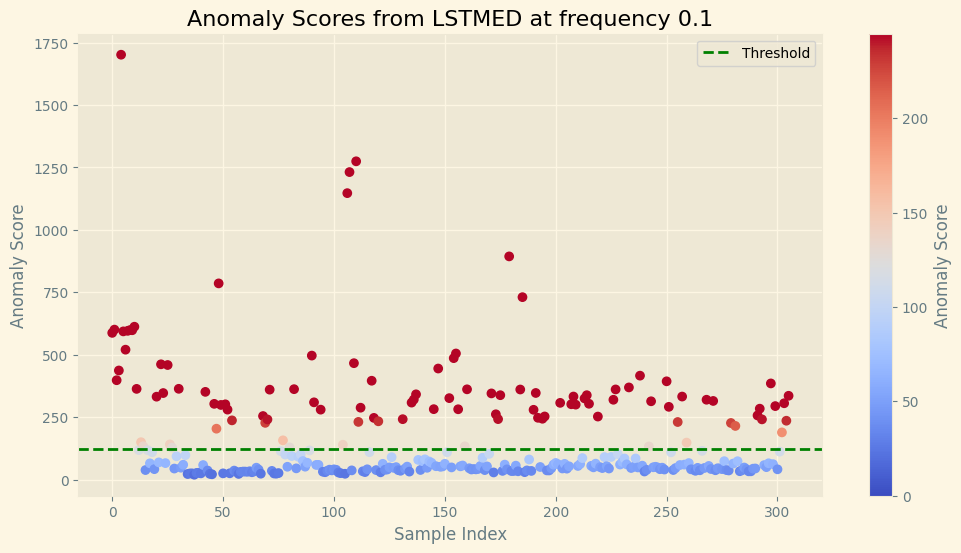

Number of anomalies detected: 105


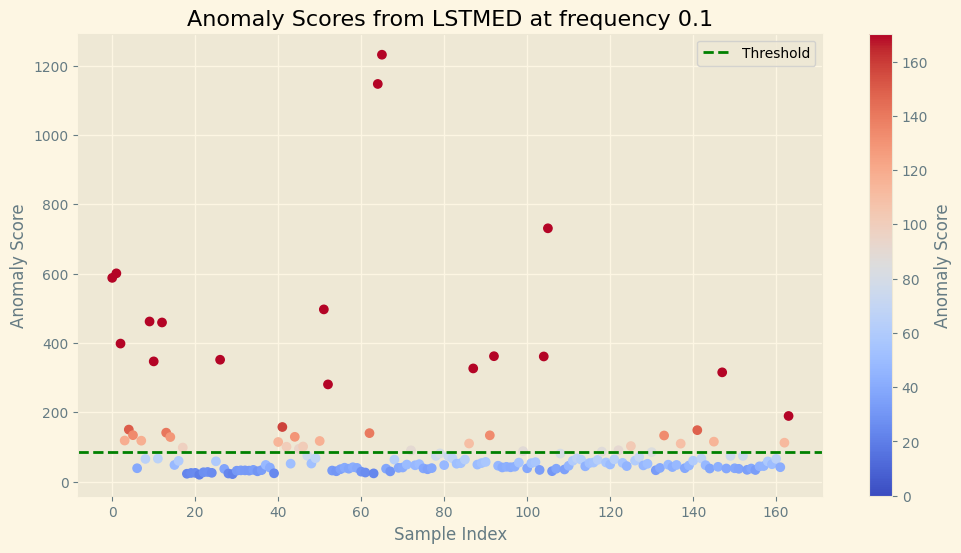

Number of anomalies detected: 44


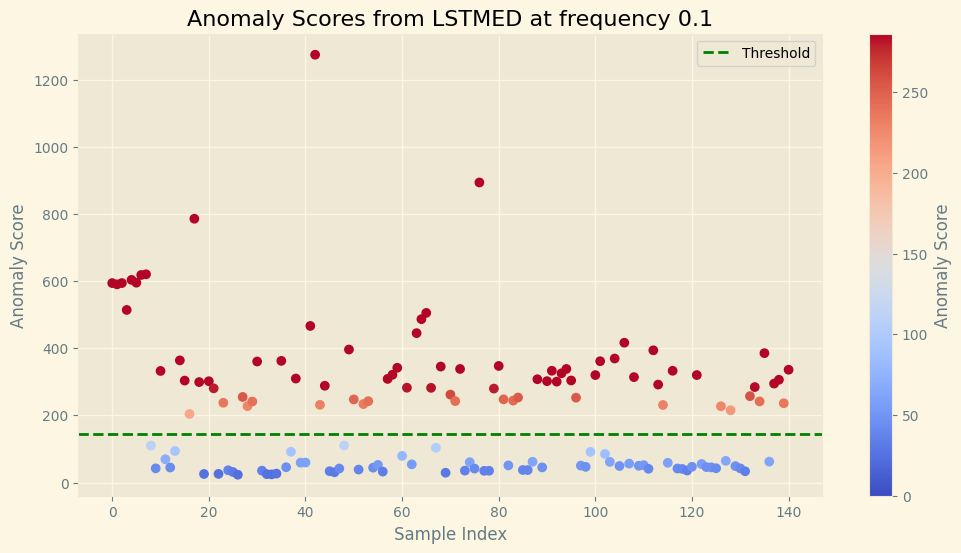

Number of anomalies detected: 77


In [33]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[1])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[1])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[1]/4)

In [34]:
X_test_start_end['anomaly_scores'] = anomaly_scores
X_test_start_end['is_collision'] = y_collisions_predict
X_test_start_end1['anomaly_scores'] = anomaly_scores1
X_test_start_end1['is_collision'] = y_collisions_predict1
X_test_start_end5['anomaly_scores'] = anomaly_scores5
X_test_start_end5['is_collision'] = y_collisions_predict5

In [35]:
compute_metrics(anomaly_scores, y_collision, thresholds[1])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[1])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[1])

Threshold: 122.3908
ROC AUC Score: 0.9367
F1 Score: 0.8571
Accuracy: 0.9020
Precision: 0.8571
Recall: 0.8571
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       201
           1       0.86      0.86      0.86       105

    accuracy                           0.90       306
   macro avg       0.89      0.89      0.89       306
weighted avg       0.90      0.90      0.90       306

############################################
Threshold: 85.1296
ROC AUC Score: 0.9542
F1 Score: 0.8354
Accuracy: 0.9207
Precision: 0.7500
Recall: 0.9429
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       129
           1       0.75      0.94      0.84        35

    accuracy                           0.92       164
   macro avg       0.87      0.93      0.89       164
weighted avg       0.93      0.92      0.92       164

############################################
Threshold: 572.4641
ROC AUC Score: 0.89

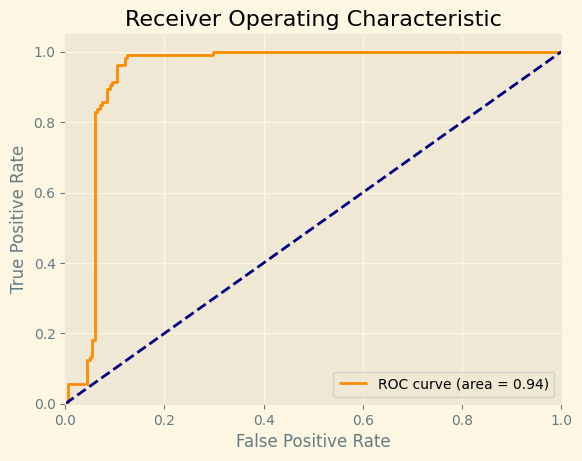

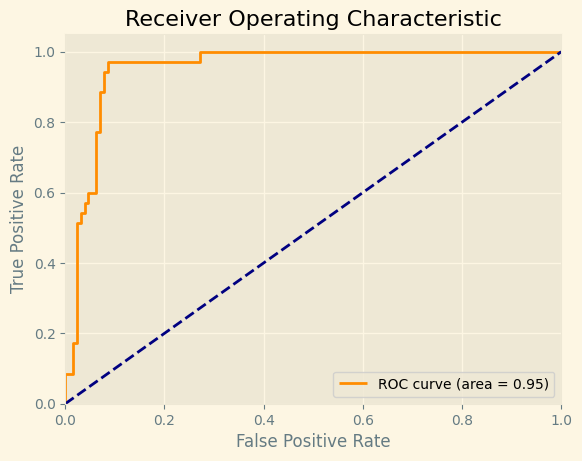

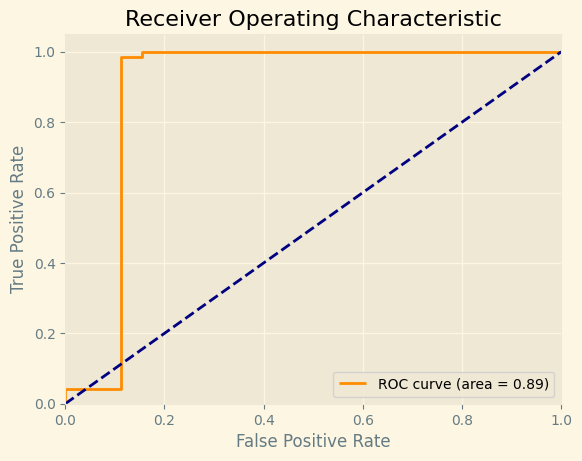

In [36]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

In [37]:
def convert_to_df(collisions_zones):
    collisions_zones_df = pd.DataFrame(collisions_zones)
    # change the type of the columns to datetime
    collisions_zones_df['start'] = pd.to_datetime(collisions_zones_df['start'])
    collisions_zones_df['end'] = pd.to_datetime(collisions_zones_df['end'])
    
    return collisions_zones_df

In [38]:
collisions_zones_df = convert_to_df(collisions_zones)
collisions_zones_df_1 = convert_to_df(collisions_zones_1)
collisions_zones_df_5 = convert_to_df(collisions_zones_5)

In [39]:
plot_anomalies_true_and_predicted(df_collision, df_action_collision, collisions_zones_df, X_test_start_end, title="Normal data with predicted collisions", saveplot=False)

In [40]:
plot_anomalies_true_and_predicted(df_collision_1, df_action_collision_1, collisions_zones_df_1, X_test_start_end1, title="Collision 1 data with predicted collisions", saveplot=False)

In [41]:
plot_anomalies_true_and_predicted(df_collision_5, df_action_collision_5, collisions_zones_df_5, X_test_start_end5, title="Collision 5 data with predicted collisions", saveplot=False)